In [1]:
!pip install patchify

# Import Libraries

In [16]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Hyperparameters

In [17]:
img_size = 224
num_channels = 3
patch_size = 25
num_patches = (img_size // patch_size) ** 2
flat_patches_shape = (num_patches, patch_size * patch_size * num_channels)

batch_size = 32
lr = 1e-4
num_epochs = 10
num_classes = 2
class_names = ['bleeding', 'non-bleeding']

# Load Data

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

if not os.path.exists('files'):
    os.makedirs('files')

PATH = '/kaggle/input/wcebleedgenai/WCEBleedGen'
model_path = os.path.join('files', 'model.keras')
log_path = os.path.join('files', 'log.csv')

# Train / Validation Dataset

In [34]:
bleed_images = glob(os.path.join(PATH, 'bleeding/Images', '*.png'))
nonbleed_images = glob(os.path.join(PATH, 'non-bleeding/images', '*.png'))

if not bleed_images or not nonbleed_images:
    raise ValueError("No images found in 'bleed' or 'nonbleed' folders.")

bleed_images = shuffle(bleed_images, random_state=42)
nonbleed_images = shuffle(nonbleed_images, random_state=42)

train = bleed_images + nonbleed_images
train_x, valid_x = train_test_split(train, test_size=0.1, random_state=42)

train_x = shuffle(train_x, random_state=42)
valid_x = shuffle(valid_x, random_state=42)

print(f"Total: {len(bleed_images)+len(nonbleed_images)}, Train: {len(train_x)}, Validation: {len(valid_x)}")

Total: 2618, Train: 2356, Validation: 262


# Process Images, Patches and Labels

In [35]:
def process_img_label(path):
    """Reading Images"""
    path = path.decode()
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    
    """Patches"""
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)
    patches = np.reshape(patches, flat_patches_shape)
    patches = patches.astype(np.float32)
    
    """Labels"""
    class_name = path.split('/')[-3]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx

In [36]:
def parse(path):
    patches, labels = tf.numpy_function(process_img_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, num_classes)
    
    patches.set_shape(flat_patches_shape)
    labels.set_shape(num_classes)
    
    return patches, labels

In [37]:
def tf_dataset(images, batch=32):
    data = tf.data.Dataset.from_tensor_slices((images))
    data = data.map(parse).batch(batch).prefetch(8)
    return data

# ViT Model

In [38]:
"""ViT Model Hyperparameters"""
num_layers = 12
hidden_dim = 768
mlp_dim = 3072
num_heads = 12
dropout_rate = 0.1

In [39]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1,1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )
    
    def call(self, inputs):
        batch_size__ = tf.shape(inputs)[0]
        hidden_dim__ = self.w.shape[-1]
        
        cls = tf.broadcast_to(self.w, [batch_size__, 1, hidden_dim__])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [40]:
def mlp(x):
    x = Dense(mlp_dim, activation="gelu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(hidden_dim)(x)
    x = Dropout(dropout_rate)(x)
    return x

In [41]:
def transformer_encoder(x):
    skip1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=num_heads, key_dim=hidden_dim
    )(x, x)
    x = Add()([x, skip1])
    skip2 = x
    x = LayerNormalization()(x)
    x = mlp(x)
    x = Add()([x, skip2])
    
    return x

In [42]:
def ViT():
    """Input"""
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = Input(input_shape)
    
    """Patch + Embeddings"""
    patch_embed = Dense(hidden_dim)(inputs)
    
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    
    embed = patch_embed + pos_embed
    
    """Adding Class Token"""
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed])
    
    for _ in range(num_layers):
        x = transformer_encoder(x)
    
    """Classification Head"""
    x = LayerNormalization()(x)
    x = x[:, 0, :]
    
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    return model

# Training

In [43]:
strategy = tf.distribute.MirroredStrategy()

In [44]:
batch_size = batch_size * strategy.num_replicas_in_sync

In [45]:
train_data = tf_dataset(train_x, batch=batch_size)
valid_data = tf_dataset(valid_x, batch=batch_size)

In [46]:
with strategy.scope():
    model = ViT()
    model.compile(loss='categorical_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(lr, clipvalue=1.0),
             metrics=['acc'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 1875)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64, 768)   │  1,440,768 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 64, 768)   │          0 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_token_1       │ (None, 1, 768)    │          0 │ add_25[0][0]      │
│ (ClassToken)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 65, 768)   │          0 │ class_token_1[0]… │
│ (Concatenate)       │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 768)   │      1,536 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 768)   │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 65, 768)   │          0 │ multi_head_atten… │
│                     │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 768)   │      1,536 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 65, 3072)  │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 65, 3072)  │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 65, 768)   │  2,360,064 │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 65, 768)   │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 65, 768)   │          0 │ dropout_38[0][0], │
│                     │                   │            │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 768)   │      1,536 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 768)   │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 65, 768)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_27[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 768)   │      1,536 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 398,229,506 (1.48 GB)

 Trainable params: 398,229,506 (1.48 GB)

 Non-trainable params: 0 (0.00 B)

In [47]:
callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
    CSVLogger(log_path),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
]

model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=valid_data,
    callbacks=callbacks
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.4896 - loss: 3.4024
Epoch 1: val_loss improved from inf to 0.71860, saving model to files/model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - acc: 0.4895 - loss: 3.3794 - val_acc: 0.5038 - val_loss: 0.7186 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.5251 - loss: 0.7009
Epoch 2: val_loss improved from 0.71860 to 0.48723, saving model to files/model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - acc: 0.5259 - loss: 0.7004 - val_acc: 0.7710 - val_loss: 0.4872 - learning_rate: 1.0000e-04
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.8703 - loss: 0.3453
Epoch 3: val_loss improved from 0.48723 to 0.17006, saving model to files/model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - acc: 0.8706 - loss: 0.3445 - val_acc: 0.9427 - val_loss: 0.1701 - learning_rate: 1.0000e-04
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9394 - loss: 0.1658
Epoch 4: val_loss did not improv

# Loss and Validation Plots

In [48]:
df = pd.read_csv('/kaggle/working/files/log.csv')
df # training log

,epoch,acc,learning_rate,loss,val_acc,val_loss
0,0,0.485569,0.0001,1.682697,0.503817,0.718596
1,1,0.586587,0.0001,0.664709,0.770992,0.487229
2,2,0.892615,0.0001,0.289480,0.942748,0.170064
3,3,0.935908,0.0001,0.171695,0.923664,0.248863
4,4,0.946520,0.0001,0.139920,0.980916,0.070302
5,5,0.955857,0.0001,0.120448,0.969466,0.086276
6,6,0.962649,0.0001,0.105840,0.912214,0.185882
7,7,0.964771,0.0001,0.096301,0.965649,0.083101
8,8,0.976655,0.0001,0.067470,0.984733,0.061610
9,9,0.976231,0.0001,0.067544,0.973282,0.065806


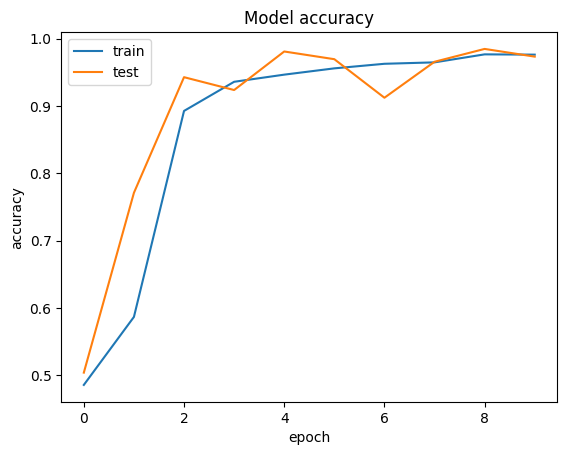

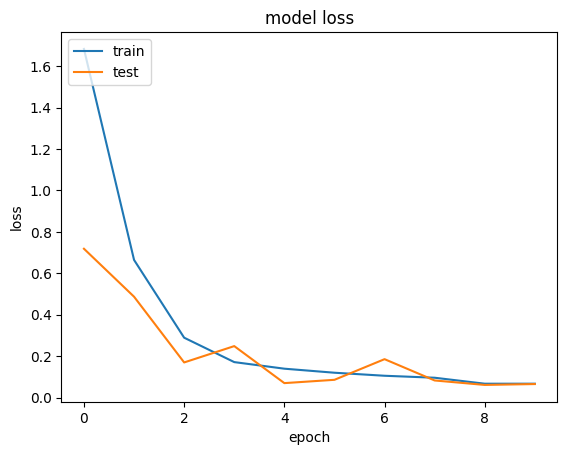

In [49]:
plt.plot(df['acc'])
plt.plot(df['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Data

In [56]:
TEST_PATH = '/kaggle/input/bleedgendata/WCEBleedGen_Test/Auto-WCEBleedGen Challenge Test Dataset'
test_data_1 = glob(os.path.join(TEST_PATH, 'Test Dataset 1', '*.png'))
test_data_2 = glob(os.path.join(TEST_PATH, 'Test Dataset 2', '*.png'))

test_data = test_data_1 + test_data_2

In [57]:
model.load_weights(model_path)

In [58]:
predicted_df = pd.DataFrame(columns=['ID', 'Predicted_Class'])

In [59]:
def predict_single_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)
    patches = np.reshape(patches, flat_patches_shape)
    patches = patches.astype(np.float32)
    
    patches = tf.expand_dims(patches, axis=0)
    
    predictions = model.predict(patches)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    
    return predicted_class

In [63]:
predicted_df = pd.DataFrame(columns=['ID', 'Predicted_Class'])
def add_prediction(predicted_df, image_id, predicted_class):
    new_row = pd.DataFrame({
        'ID': [image_id],
        'Predicted_Class': [predicted_class]
    })
    predicted_df = pd.concat([predicted_df, new_row], ignore_index=True)
    return predicted_df
for image_path in test_data:
    image_id = os.path.basename(image_path)
    predicted_class = predict_single_image(image_path)
    add_prediction(predicted_df,image_id,predicted_class)
    
    
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━

In [64]:
predicted_df.to_csv('predictions.csv', index=False)

# Accuracy, Recall, F1-Score
## on Validation Dataset

In [65]:
valid_x[0].split('/')[-3], class_names[predict_single_image(test_data[0])]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


('non-bleeding', 'bleeding')

In [66]:
y_true = []
y_pred = []
for i, p in enumerate(valid_x):
    y = valid_x[i]
    y_true.append(y.split('/')[-3])
for i, j in enumerate(valid_x):
    y_pred.append(class_names[predict_single_image(valid_x[i])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

In [67]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    bleeding       1.00      0.97      0.98       130
non-bleeding       0.97      1.00      0.99       132

    accuracy                           0.98       262
   macro avg       0.99      0.98      0.98       262
weighted avg       0.99      0.98      0.98       262



In [68]:
cm = confusion_matrix(y_true, y_pred)

In [69]:
print(cm)

[[126   4]
 [  0 132]]
